### Install package

In [1]:
!pip install pytorch-adapt[ignite] seaborn pandas umap-learn

     |████████████████████████████████| 132 kB 13.7 MB/s 
     |████████████████████████████████| 86 kB 6.9 MB/s 
     |████████████████████████████████| 1.1 MB 52.2 MB/s 
     |████████████████████████████████| 106 kB 48.7 MB/s 
     |████████████████████████████████| 396 kB 59.4 MB/s 
     |████████████████████████████████| 251 kB 70.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=d87c1544cb2906396be0f5c68242b88dc79b00936a248d954495786a29c21705
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=4d391a18cb9e7e5b4f23d33a6e8119e6e1ea96dba2e83cd6783ef0b93c4e2689
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


### Import packages

In [2]:
import logging

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import umap
from ignite.engine import Events

from pytorch_adapt.adapters import DANN
from pytorch_adapt.containers import Models, Optimizers
from pytorch_adapt.datasets import DataloaderCreator, get_mnist_mnistm
from pytorch_adapt.frameworks.ignite import Ignite, savers
from pytorch_adapt.models import Discriminator, mnistC, mnistG
from pytorch_adapt.validators import AccuracyValidator, IMValidator, ScoreHistory

logging.basicConfig()
logging.getLogger("pytorch-adapt").setLevel(logging.INFO)

In [3]:
def get_viz_fn(trainer, dc, datasets):
    def viz(_):
        features, domain = [], []

        for x in ["src_val", "target_val"]:
            dataloader = dc(**{x: datasets[x]})[x]
            output = trainer.get_all_outputs(dataloader, x)
            features.append(output[x]["features"])
            domain.append(output[x]["domain"])

        features = torch.cat(features, dim=0).cpu().numpy()
        domain = torch.cat(domain, dim=0).cpu().numpy()
        emb = umap.UMAP().fit_transform(features)

        df = pd.DataFrame(emb).assign(domain=domain)
        df["domain"] = df["domain"].replace({0: "Source", 1: "Target"})
        sns.set_theme(style="white", rc={"figure.figsize": (12.8, 9.6)})
        sns.scatterplot(data=df, x=0, y=1, hue="domain", s=2)
        plt.show()

    return viz

### Create datasets and dataloaders

In [4]:
datasets = get_mnist_mnistm(["mnist"], ["mnistm"], folder=".", download=True)
dc = DataloaderCreator(batch_size=64, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/134178716 [00:00<?, ?it/s]

INFO:pytorch-adapt:Extracting dataset
100%|██████████| 68007/68007 [00:11<00:00, 6074.82it/s]


### Create models, optimizers, hook, and validator

In [5]:
G = mnistG(pretrained=True)
C = mnistC(pretrained=True)
# move first 6 layers of C to G
G.fc = C.net[:6]
C.net = C.net[6:]

D = Discriminator(in_size=128, h=256)
models = Models({"G": G, "C": C, "D": D})
optimizers = Optimizers((torch.optim.Adam, {"lr": 0.0005}))

adapter = DANN(models=models, optimizers=optimizers)
saver = savers.Saver(folder="saved_models")
validator = ScoreHistory(IMValidator())
val_hook = ScoreHistory(AccuracyValidator())
trainer = Ignite(adapter, validator=validator, val_hook=val_hook, saver=saver)

Downloading: "https://cornell.box.com/shared/static/tdx0ts24e273j7mf3r2ox7a12xh4fdfy" to /root/.cache/torch/hub/checkpoints/mnistG-68ee7945.pth


  0%|          | 0.00/161k [00:00<?, ?B/s]

Downloading: "https://cornell.box.com/shared/static/j4zrogronmievq1csulrkai7zjm27gcq" to /root/.cache/torch/hub/checkpoints/mnistC-ac7b5a13.pth


  0%|          | 0.00/1.31M [00:00<?, ?B/s]

### Attach visualization function

In [6]:
viz_condition = Events.EPOCH_COMPLETED(every=2) | Events.STARTED
viz_fn = get_viz_fn(trainer, dc, datasets)
trainer.trainer.add_event_handler(viz_condition, viz_fn)

### Train and evaluate

INFO:pytorch-adapt:Collecting src_val
INFO:pytorch-adapt:Setting models to eval() mode


[1/157]   1%|          |it [00:00<?]

INFO:pytorch-adapt:Collecting target_val
INFO:pytorch-adapt:Setting models to eval() mode


[1/141]   1%|          |it [00:00<?]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


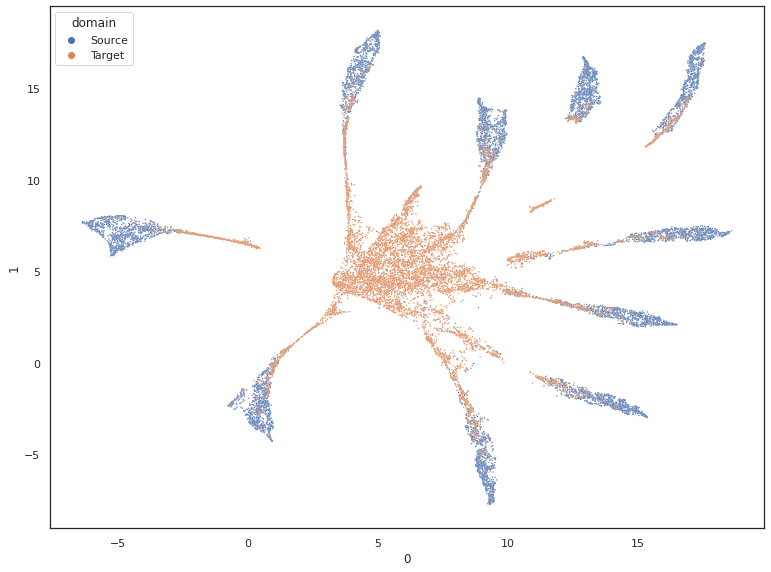

INFO:pytorch-adapt:Setting models to train() mode


[1/921]   0%|          |it [00:00<?]

INFO:pytorch-adapt:Collecting src_val
INFO:pytorch-adapt:Setting models to eval() mode


[1/157]   1%|          |it [00:00<?]

INFO:pytorch-adapt:Collecting target_train
INFO:pytorch-adapt:Setting models to eval() mode


[1/922]   0%|          |it [00:00<?]

INFO:pytorch-adapt:Saving validator to saved_models
INFO:pytorch-adapt:Saving adapter to saved_models
INFO:pytorch-adapt:Saving val_hook to saved_models
INFO:pytorch-adapt:VALIDATION SCORES:
ScoreHistory(
  validator=IMValidator(
    required_data=['target_train']
    weights={'entropy': 1, 'diversity': 1}
    (entropy): EntropyValidator(required_data=['target_train'])
    (diversity): DiversityValidator(required_data=['target_train'])
  )
  latest_score=1.166610985994339
  best_score=1.166610985994339
  best_epoch=1
)
OTHER STATS:
ScoreHistory(
  validator=AccuracyValidator(required_data=['src_val'])
  latest_score=0.9912999868392944
  best_score=0.9912999868392944
  best_epoch=1
)

INFO:pytorch-adapt:Saving Ignite engine to saved_models
INFO:pytorch-adapt:Setting models to train() mode


[1/921]   0%|          |it [00:00<?]

INFO:pytorch-adapt:Collecting src_val
INFO:pytorch-adapt:Setting models to eval() mode


[1/157]   1%|          |it [00:00<?]

INFO:pytorch-adapt:Collecting target_val
INFO:pytorch-adapt:Setting models to eval() mode


[1/141]   1%|          |it [00:00<?]

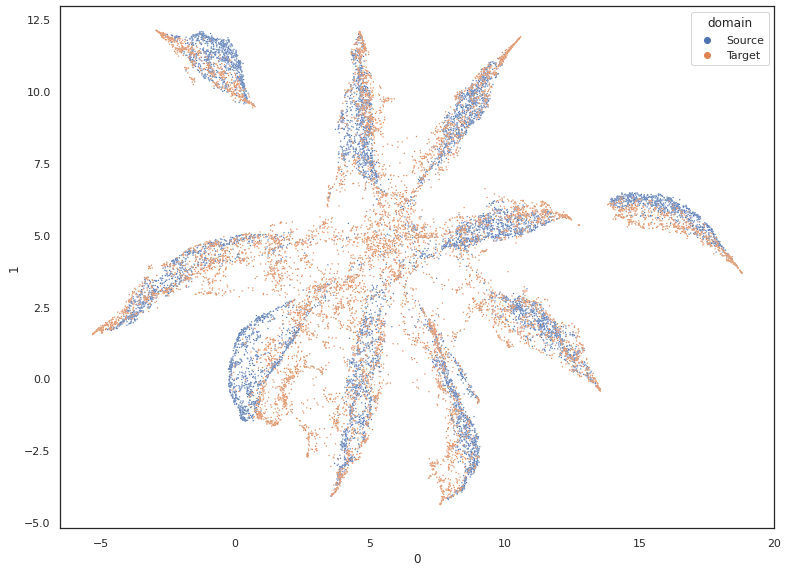

INFO:pytorch-adapt:Collecting src_val
INFO:pytorch-adapt:Setting models to eval() mode


[1/157]   1%|          |it [00:00<?]

INFO:pytorch-adapt:Collecting target_train
INFO:pytorch-adapt:Setting models to eval() mode


[1/922]   0%|          |it [00:00<?]

INFO:pytorch-adapt:Saving validator to saved_models
INFO:pytorch-adapt:Saving adapter to saved_models
INFO:pytorch-adapt:Saving val_hook to saved_models
INFO:pytorch-adapt:VALIDATION SCORES:
ScoreHistory(
  validator=IMValidator(
    required_data=['target_train']
    weights={'entropy': 1, 'diversity': 1}
    (entropy): EntropyValidator(required_data=['target_train'])
    (diversity): DiversityValidator(required_data=['target_train'])
  )
  latest_score=0.5892638266086578
  best_score=1.166610985994339
  best_epoch=1
)
OTHER STATS:
ScoreHistory(
  validator=AccuracyValidator(required_data=['src_val'])
  latest_score=0.9918000102043152
  best_score=0.9918000102043152
  best_epoch=2
)

INFO:pytorch-adapt:Saving Ignite engine to saved_models
INFO:pytorch-adapt:Setting models to train() mode
INFO:pytorch-adapt:epochs_since_best_epoch = 1


[1/921]   0%|          |it [00:00<?]

INFO:pytorch-adapt:Collecting src_val
INFO:pytorch-adapt:Setting models to eval() mode


[1/157]   1%|          |it [00:00<?]

INFO:pytorch-adapt:Collecting target_train
INFO:pytorch-adapt:Setting models to eval() mode


[1/922]   0%|          |it [00:00<?]

INFO:pytorch-adapt:Saving validator to saved_models
INFO:pytorch-adapt:Saving adapter to saved_models
INFO:pytorch-adapt:Saving val_hook to saved_models
INFO:pytorch-adapt:VALIDATION SCORES:
ScoreHistory(
  validator=IMValidator(
    required_data=['target_train']
    weights={'entropy': 1, 'diversity': 1}
    (entropy): EntropyValidator(required_data=['target_train'])
    (diversity): DiversityValidator(required_data=['target_train'])
  )
  latest_score=0.8284833207726479
  best_score=1.166610985994339
  best_epoch=1
)
OTHER STATS:
ScoreHistory(
  validator=AccuracyValidator(required_data=['src_val'])
  latest_score=0.9896000027656555
  best_score=0.9918000102043152
  best_epoch=2
)

INFO:pytorch-adapt:Saving Ignite engine to saved_models
INFO:pytorch-adapt:Setting models to train() mode
INFO:pytorch-adapt:epochs_since_best_epoch = 2


[1/921]   0%|          |it [00:00<?]

INFO:pytorch-adapt:Collecting src_val
INFO:pytorch-adapt:Setting models to eval() mode


[1/157]   1%|          |it [00:00<?]

INFO:pytorch-adapt:Collecting target_val
INFO:pytorch-adapt:Setting models to eval() mode


[1/141]   1%|          |it [00:00<?]

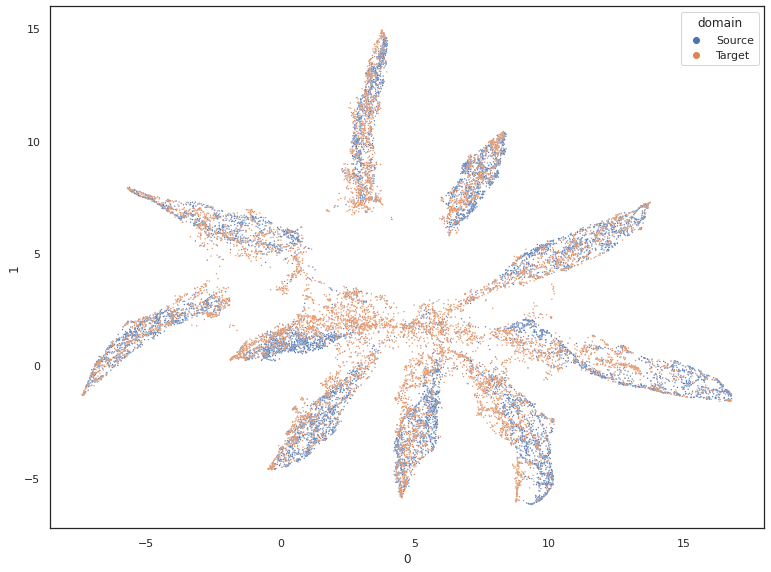

INFO:pytorch-adapt:Collecting src_val
INFO:pytorch-adapt:Setting models to eval() mode


[1/157]   1%|          |it [00:00<?]

INFO:pytorch-adapt:Collecting target_train
INFO:pytorch-adapt:Setting models to eval() mode


[1/922]   0%|          |it [00:00<?]

INFO:pytorch-adapt:Saving validator to saved_models
INFO:pytorch-adapt:Saving adapter to saved_models
INFO:pytorch-adapt:Saving val_hook to saved_models
INFO:pytorch-adapt:VALIDATION SCORES:
ScoreHistory(
  validator=IMValidator(
    required_data=['target_train']
    weights={'entropy': 1, 'diversity': 1}
    (entropy): EntropyValidator(required_data=['target_train'])
    (diversity): DiversityValidator(required_data=['target_train'])
  )
  latest_score=0.8492492437362671
  best_score=1.166610985994339
  best_epoch=1
)
OTHER STATS:
ScoreHistory(
  validator=AccuracyValidator(required_data=['src_val'])
  latest_score=0.9894999861717224
  best_score=0.9918000102043152
  best_epoch=2
)

INFO:pytorch-adapt:Saving Ignite engine to saved_models


best_score=1.166610985994339, best_epoch=1


In [7]:
best_score, best_epoch = trainer.run(datasets, dataloader_creator=dc, max_epochs=4)
print(f"best_score={best_score}, best_epoch={best_epoch}")

### Check accuracy on target data (not possible in real-world applications)

In [8]:
datasets = get_mnist_mnistm(
    ["mnist"], ["mnistm"], folder=".", return_target_with_labels=True
)
dc = DataloaderCreator(batch_size=64, num_workers=2, all_val=True)
validator = AccuracyValidator(key_map={"target_val_with_labels": "src_val"})
score = trainer.evaluate_best_model(datasets, validator, dc)
print(score)

INFO:pytorch-adapt:***EVALUATING BEST MODEL***
INFO:pytorch-adapt:Loading adapter from saved_models
INFO:pytorch-adapt:Collecting target_val_with_labels
INFO:pytorch-adapt:Setting models to eval() mode


[1/141]   1%|          |it [00:00<?]

0.6118209362030029
